In [1]:
%matplotlib inline
import itertools
import numpy as np
import matplotlib
# matplotlib.use('PS')
from matplotlib import pyplot as plt
plt.style.use('bmh')
from numba import jit
from numba import njit
from time import time
# Spline interpolation
from scipy.interpolate import RectBivariateSpline
# Multiprocessing:
from concurrent import futures as fut
from concurrent.futures import ProcessPoolExecutor, as_completed

from ipywidgets import FloatProgress
from IPython.display import display

from scipy.interpolate import interp1d

import sys
# PATH = '$HOME/git/LCS/notebooks'
sys.path.insert(0, './utility/')
import importlib

In [10]:
factor = 10

Nx = 100 * factor
Ny = 50 * factor

max_notAB =  0.3
h = 0.001
n__=8
n = n__
fig_s = (14, int(14 * Ny / Nx))

t0 = 0
dt = .1
h_ = dt
steps = 200
tmax = dt * steps
spat_res = 0.01
epsilon = 1 #unused?

import double_gyre
importlib.reload(double_gyre)#do a reload to set A and e properly
gyreObj = double_gyre
A_ = 0.1
e_ = 0.2
gyreObj.setGyreVars(A_, e_)
grid_of_particles = gyreObj.grid_of_particles
doublegyre = gyreObj.doublegyre
f = gyreObj.f

# import norkyst
# importlib.reload(norkyst)

# norkystObj = norkyst.norkystHandler(False)
# norkystObj(Nx, Ny)
# grid_of_particles = norkystObj.grid_of_particles
# f = norkystObj.f


X0 = np.load('../data/X0m_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))

strain_path = 'strainlines/strainlines-AB{:05.2f}-h{:1.4f}-nx{:d}-ny{:d}-n{}'.format(max_notAB, np.abs(h), Nx, Ny,n)
lambda2 = np.load(strain_path + '/lambda2.npy')
ABtrue = np.load(strain_path + '/ABtrue.npy')

In [11]:
##load lines for advection
import os
from os import path

advection_path = 'advection'
advect_file_ = 'AB{:05.2f}-h{:1.4f}-nx{:d}-ny{:d}-n{:d}.npy'.format(max_notAB, np.abs(h), Nx, Ny, (n__))

BACK = True
FORW = True


if BACK:
    b_lines_ = np.load(advection_path + '/backwards-' + advect_file_)
if FORW:
    f_lines_ = np.load(advection_path + '/forwards-' + advect_file_)
##flags for forward and backward



In [12]:
def endpoints(X0, tmax, h, integrator, f, t=0):
    # Number of timesteps
    Nt = np.abs(int((tmax - t) / h))
    # Array to hold positions
    X  = np.zeros((*X0.shape,))
    # Initial position
    X[:,:] = X0
    # Loop over all timesteps
    i = 1
    
    while np.abs(t) < np.abs(tmax):
        # Ensure we end up at correct time
        if h > 0:
            h = min(h,tmax - t)
        elif h < 0:
            h = min(h,-tmax + t)
        X = integrator(X, t, h, f)
        t += h
        i += 1
    # Return entire trajectory
    return X
def rk4(X, t, h, f):
    k1 = f(X,          t)
    k2 = f(X + k1*h/2., t + h/2.)
    k3 = f(X + k2*h/2., t + h/2.)
    k4 = f(X + k3*h,   t + h)
    return X + h*(k1 + 2.*k2 + 2.*k3 + k4) / 6.
def endpoints_lines_(X0, tmax, h, integrator, f, t=0):
    # Number of timesteps
    Nt = int((tmax - t) / h)
    # Array to hold positions
    X  = np.zeros((*X0.shape,))
    # Initial position
    X[:,:] = X0
    # Loop over all timesteps
    i = 1
    
    while t < tmax:
        # Ensure we end up at correct time
        h = min(h, tmax - t)
        X = integrator(X, t, h, f)
        t += h
        i += 1
    # Return entire trajectory
    return X

In [13]:
def inc_line_res(lines_, inc_res=4):
    num_lines = len(lines_)
    leng = len(lines_[0, 0, :])
    extra_points = inc_res
    linspace0 = np.linspace(0, 1, leng)
    linspace1 = np.linspace(0, 1, int(extra_points*leng))
    out = np.zeros((num_lines, 2, int(extra_points*lines_.shape[2])))
    for i in range(num_lines):
        
        interp_line = interp1d(
                                  linspace0,
                                  lines_[i,]
                                )
        line_inerp = interp_line(linspace1)
        out[i,] = line_inerp
    return out

def advec_lines(lines_, tmax, h, rk4, f, t=0):
    num_lines = len(lines_)
    adv_lines = np.zeros((lines_.shape))
    for i in range(num_lines):
        adv_lines[i,] = (endpoints_lines_(lines_[i,], tmax, h, rk4, f, t=t))
    return adv_lines

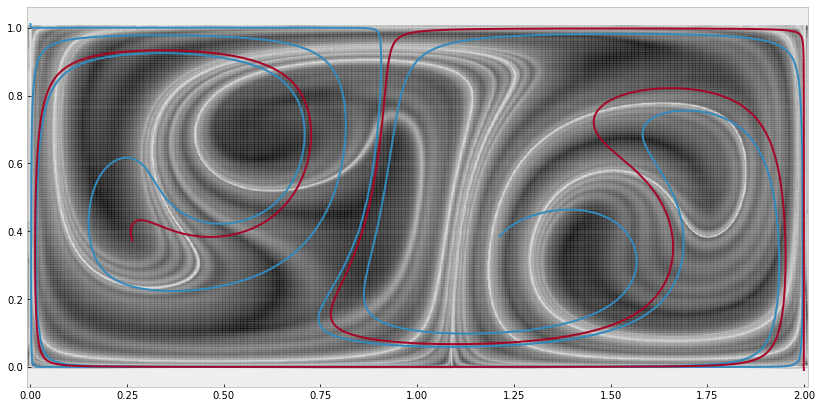

In [14]:
if BACK:
    lines_ = b_lines_
elif FORW:
    lines_ = f_lines_

fig = plt.figure(figsize=fig_s)
for i in range(lines_.shape[0]):
    plt.plot(lines_[i,0,], lines_[i,1,], lw=2)

plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax, alpha=0.3, cmap='gray')
plt.savefig('out/ftle-promising-lines0.png')
lines_ = inc_line_res(lines_, 5)

In [15]:
# lines_

In [33]:
if FORW: advected_lines_forw = advec_lines(f_lines_, 100*dt, dt*.1, rk4, f, t = t0)
if BACK: advected_lines_back = advec_lines(b_lines_, 100*dt, dt*.1, rk4, f, t = t0)

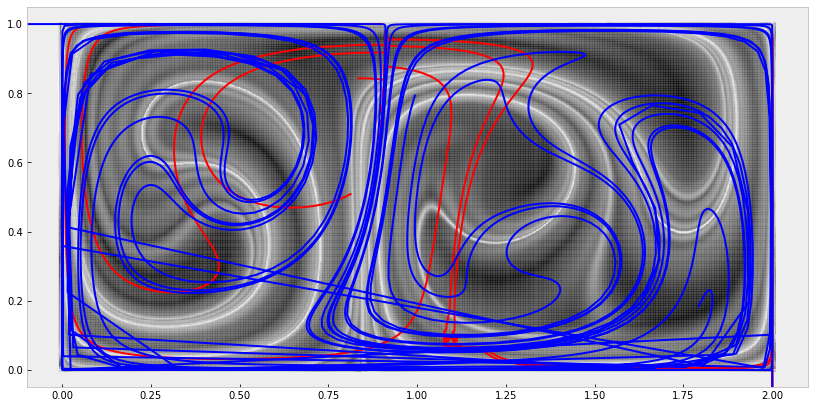

In [35]:
fig = plt.figure(figsize=fig_s)
strain_path = 'strainlines/strainlines-AB{:05.2f}-h{:1.4f}-nx{:d}-ny{:d}-n{}'.format(.31, np.abs(h), Nx, Ny,8)
lambda2 = np.load(strain_path + '/lambda2.npy')

plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax, alpha=0.3, cmap='gray')
if FORW:
    for i in range(len(advected_lines_forw)):
        plt.plot(advected_lines_forw[i,0,:], advected_lines_forw[i,1,:], lw=2, c='r')
if BACK:
    for i in range(len(advected_lines_back)):
        plt.plot(advected_lines_back[i,0,:], advected_lines_back[i,1,:], lw=2, c='b')
plt.xlim(-.1,2.1)
plt.ylim(-.05,1.05)
plt.savefig('out/ftle-promising-lines-advected4.png')

In [36]:
# lines_ = np.zeros((len(ADVECTION_LINES), 2, X.shape[1]))
# line_nr = np.argmax(flengths)
# fig = plt.figure(figsize=fig_s)
# ite= 0
# plt.pcolormesh(X0[0,:,:], X0[1,:,:], np.log(lambda2)/tmax, alpha=0.3, cmap='gray')
# for i in set((ADVECTION_LINES)):
#     lines_[ite,0,:] = X[i, :]
#     lines_[ite,1,:] = y[i, :]
#     plt.plot(lines_[ite,0,], lines_[ite,1,], lw=2)
#     ite+=1
# plt.savefig('out/ftle-promising-real-lines.png')

In [43]:

tm = 100*h_
steps = int(tm/h_)*5
dt = tm / steps
dt

0.02

(2, 1000, 500)
(2, 200, 100)
(2, 2, 200, 100)


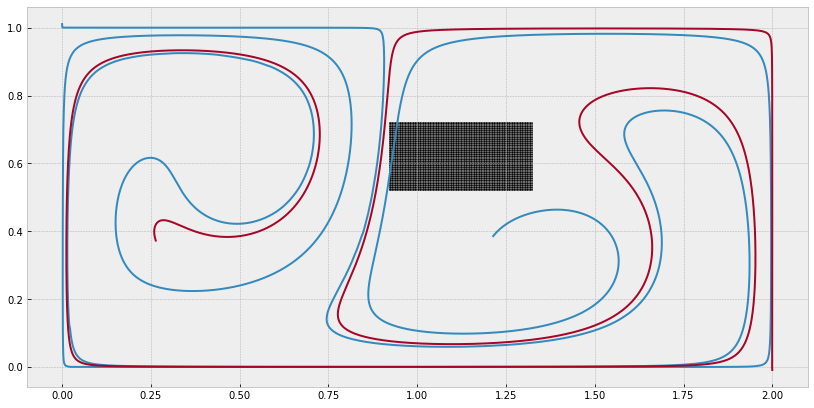

In [44]:
_part_grid = grid_of_particles(Nx, Ny, wx = 2.02, wy = 1.01)
print(_part_grid.shape)
numx = 2.3
numy = 2.6
delim = 5
small_part_grid = _part_grid[:,
                             int(_part_grid.shape[1]*numx/delim):int(_part_grid.shape[1]*(numx + 1)/delim),
                
             int(_part_grid.shape[2]*numy/delim):int(_part_grid.shape[2]*(numy + 1)/delim)]
print(small_part_grid.shape)
adv_grid = np.empty((2,2, small_part_grid.shape[1], small_part_grid.shape[2]))
print(adv_grid.shape)
adv_grid[0,] = small_part_grid
fig = plt.figure(figsize=fig_s)
for j in range(lines_.shape[0]):
    plt.plot(lines_[j,0,], lines_[j,1,], lw=2)
plt.scatter(adv_grid[0,0,], adv_grid[0,1,], c='k', s=0.1)

In [45]:
import glob
import os
filelist=glob.glob("out/movie/*.png")
for file in filelist:
    os.remove(file)

In [46]:
scale = 4


if FORW: f_l_lines_ = inc_line_res(f_lines_, scale)
if BACK: b_l_lines_ = inc_line_res(b_lines_, scale)

In [47]:

fig = plt.figure(figsize=fig_s)
for i in range(steps):
    if (i+1) % int(5*h_/(dt)) == 0:
        if FORW:
            tempf = f_l_lines_.copy()
#             adv_mov_lines_forw = np.zeros((tempf.shape[0], 2, 1*tempf.shape[2]))
            x_diff_f = np.zeros(tempf.shape[2])
            y_diff_f = np.zeros(tempf.shape[2])
            new_points_f = np.linspace(0, 1, 1*tempf.shape[2])       
            for j in range(len(f_l_lines_)):

                x_diff_f[1:-1] = tempf[j,0,1:-1] - tempf[j,0,0:-2]
                y_diff_f[1:-1] = tempf[j,1,1:-1] - tempf[j,1,0:-2]

                xs = np.cumsum(np.sqrt(x_diff_f**2 + y_diff_f**2))
                xs = xs / xs[-1]

                new_interp_line = interp1d(xs, tempf[j,])
                f_l_lines_[j,:,:] = new_interp_line(new_points_f)
        if BACK:    
            tempb = b_l_lines_.copy()
#             adv_mov_lines_back = np.zeros((tempb.shape[0], 2, 1*tempb.shape[2]))
            x_diff_b = np.zeros(tempb.shape[2])
            y_diff_b = np.zeros(tempb.shape[2])
            new_points_b = np.linspace(0, 1, 1*tempb.shape[2])
            for j in range(len(b_l_lines_)): 
                x_diff_b[1:-1] = tempb[j,0,1:-1] - tempb[j,0,0:-2]
                y_diff_b[1:-1] = tempb[j,1,1:-1] - tempb[j,1,0:-2]

                xs = np.cumsum(np.sqrt(x_diff_b**2 + y_diff_b**2))
                xs = xs / xs[-1]

                new_interp_line = interp1d(xs, tempb[j,])
                b_l_lines_[j,:,:] = new_interp_line(new_points_b)
            
            
            
   
    adv_grid[1,] = endpoints(adv_grid[0,], (i+1)*dt + t0, dt, rk4, f, t = t0 + dt*i)
    adv_grid[0,] = adv_grid[1,]
    if FORW:
        f_l_lines_ = advec_lines(f_l_lines_, (i+1)*dt + t0, dt, rk4, f, t = t0 + dt*i)
        for j in range(f_l_lines_.shape[0]):
            plt.plot(f_l_lines_[j,0,], f_l_lines_[j,1,], lw=1, c='r')
    if BACK:    
        b_l_lines_ = advec_lines(b_l_lines_, (i+1)*dt + t0, dt, rk4, f, t = t0 + dt*i)
        for j in range(b_l_lines_.shape[0]):
            plt.plot(b_l_lines_[j,0,], b_l_lines_[j,1,], lw=1, c='b')
    plt.scatter(adv_grid[1,0,::2,::2], adv_grid[1,1,::2,::2], c='k', s=1)
#     plt.xlim(X0[0,90,0], X0[0,-90,0])
#     plt.ylim(X0[1,0,90], X0[1,0,-90])
    plt.xlim(-.1,2.1)
    plt.ylim(-.05,1.05)
    plt.savefig('out/movie/advection-movie-%04d.png' % i)
    plt.clf()


<Figure size 1008x504 with 0 Axes>

In [48]:
a=1